In [52]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
# from fbprophet import Prophet

In [69]:
# importing train data to learn
train = pd.read_csv("./dataset/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
# train['DayOfWeek'] = train.index.dayofyear
# additional store data
store = pd.read_csv("./dataset/store.csv", 
                    low_memory = False)
# time series as indexes
train.index


DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [70]:
# train = train[(train["Open"] != 0) & (train['Sales'] != 0)]
def build_features(features, data):
    
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    

    return data

train_store = pd.merge(train, store, how = 'inner', on = 'Store')

build_features([], train_store)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,31,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
5,1,7,0,0,0,0,0,0,2015,7,...,30,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
6,1,6,4364,500,1,0,0,0,2015,7,...,30,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
7,1,5,3706,459,1,0,0,0,2015,7,...,30,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
8,1,4,3769,503,1,0,0,0,2015,7,...,30,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
9,1,3,3464,463,1,0,0,0,2015,7,...,30,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0


In [88]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5)

In total:  (844338, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [89]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844338.000000
mean          9.493641
std           2.197448
min           2.749075
25%           7.895571
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

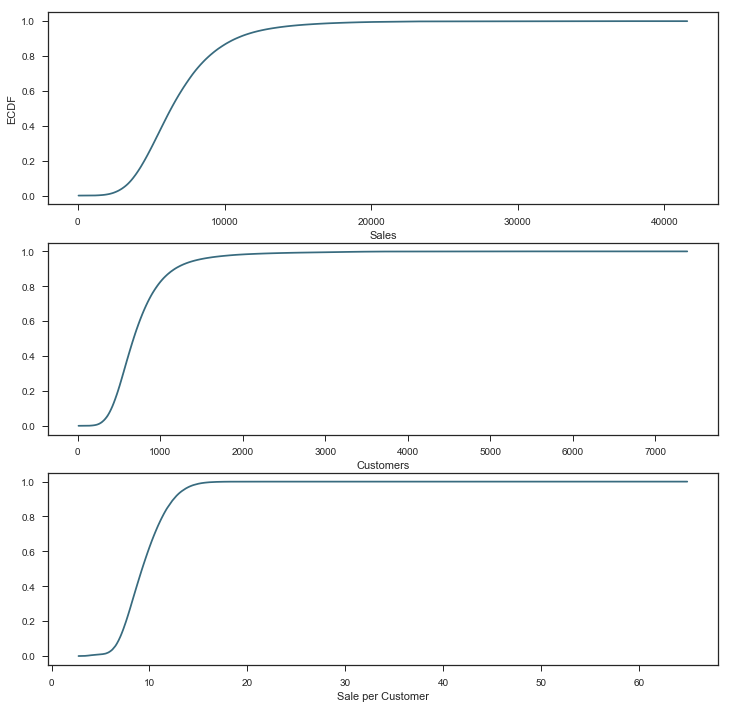

In [90]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 12))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [91]:
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

In total:  (844338, 13)


In [92]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [93]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,4,1,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,1,3,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,4,1,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).

In [94]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [95]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [96]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0


Store types
In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.

In [97]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
1,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
2,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
3,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
4,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


StoreType B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:

In [98]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
1,363541431,3165334859
2,31465616,159231395
3,92129705,783221426
4,156904995,1765392943


Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:

In [99]:
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

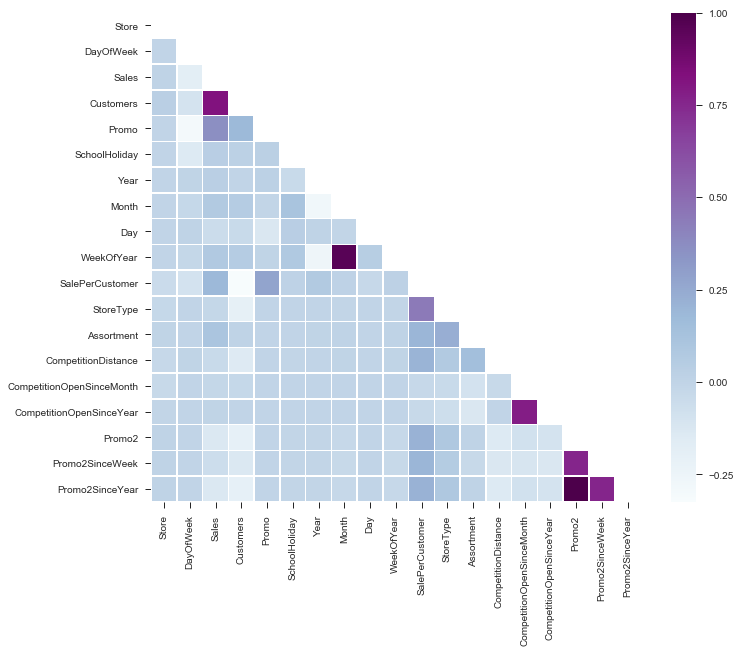

In [100]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

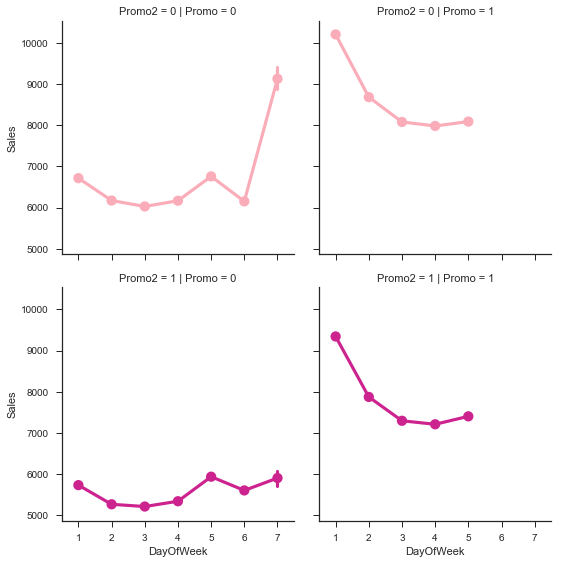

In [101]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

There are several things here:
In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

Conclusion of EDA

The most selling and crowded StoreType is A.
The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.
Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this StoreType generated the least amount of sales and customers over the whole period, it shows a great potential.
Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).
Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

In [102]:
import xgboost as xgb

In [103]:
test = pd.read_csv("./dataset/test.csv", parse_dates = True, low_memory = False, index_col = 'Date')
test = test.replace("a",1)
test = test.replace("b",2)
test = test.replace("c",3)
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear
test_store = pd.merge(test, store, how = 'inner', on = 'Store')
test_store

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,1.0,1,0,0,2015,9,17,38,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
1,857,1,3,1.0,1,0,0,2015,9,16,38,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1713,1,2,1.0,1,0,0,2015,9,15,38,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
3,2569,1,1,1.0,1,0,0,2015,9,14,38,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
4,3425,1,7,0.0,0,0,0,2015,9,13,37,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
5,4281,1,6,1.0,0,0,0,2015,9,12,37,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
6,5137,1,5,1.0,0,0,0,2015,9,11,37,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
7,5993,1,4,1.0,0,0,0,2015,9,10,37,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
8,6849,1,3,1.0,0,0,0,2015,9,9,37,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0
9,7705,1,2,1.0,0,0,0,2015,9,8,37,3,1,1270.0,9.0,2008.0,0,0.0,0.0,0


In [104]:
import math
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

In [110]:
# Store	DayOfWeek	Sales	Customers	Open	Promo	StateHoliday	SchoolHoliday	Year	Month	...	SalePerCustomer	StoreType	Assortment	CompetitionDistance	CompetitionOpenSinceMonth	CompetitionOpenSinceYear	Promo2	Promo2SinceWeek	Promo2SinceYear	PromoInterval

def get_data(train_store, test_store):
    fearures = ["DayOfWeek","Promo","Year","Month","Day","StoreType","Assortment"]
    x_train = train_store[fearures]
    y_train = train_store["Sales"]

    from sklearn.cross_validation import train_test_split
    #x为数据集的feature熟悉，y为label.
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)


    x_test = test_store[fearures]
    x_test
    dtrain = xgb.DMatrix(x_train, y_train)
    dtest = xgb.DMatrix(x_test)
    dval =  xgb.DMatrix(x_val)
    return dtrain,dval,dtest,y_val
    




In [111]:
def train_model(dtrain):
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
    num_boost_round = 3000

    bst = xgb.train(params, dtrain, num_boost_round)
    return bst

In [112]:
dtrain,dval,dtest,y_val = get_data(train_store, test_store)
bst  = train_model(dtrain)


0.44869942682471053

In [115]:
y_val_predict = bst.predict(dval)
rmspe(y_val.tolist(), y_val_predict)

# test_probs = bst.predict(dtest)

0.4486994268247108

0.4486994268247108

https://segmentfault.com/q/1010000011643773   inplcae = 1